### 2020 June 7 ICME event

figures and animations of 3DCORE fitting results

use cmesig environment!

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc

import numpy as np
from datetime import timedelta
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import multiprocessing

import astropy
import astropy.constants as const
import astropy.units as unit
from astropy.coordinates import SkyCoord


import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

from sunpy.coordinates import frames

import py3dcore
import heliosat


#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
#os.system('jupyter nbconvert --to script psp_3dcore.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
    
animdirectory='results/animations_june7'
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)
    
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


#--------------------- load solar orbiter data (made with heliocats)
filemag='data/mag/solo_2020_june_october_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 



#------------------------- load position data

#load position data (made with heliocats)
#[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
#      pickle.load( open( 'data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))

#load position data (made with heliocats)
[psp, bepi, solo, earth, mars, mercury,venus,sta,stb]= \
      pickle.load( open( 'data/positions_HCI_1hr.p', "rb" ))

#these are 1 minute HCI positions for the April May 2020 time range
#[psp, bepi, solo, earth, mars, mercury,venus,sta]= \
#      pickle.load( open( 'data/positions_HCI_1minute.p', "rb" ))


#convert to mdates
psp_numtime=mdates.date2num(psp.time)
bepi_numtime=mdates.date2num(bepi.time)
solo_numtime=mdates.date2num(solo.time)
sta_numtime=mdates.date2num(sta.time)
earth_numtime=mdates.date2num(earth.time)




#convert to mdates
#psp_numtime=psp.time+mdates.date2num(np.datetime64('0000-12-31')) 
#bepi_numtime=bepi.time+mdates.date2num(np.datetime64('0000-12-31'))
#solo_numtime=solo.time+mdates.date2num(np.datetime64('0000-12-31'))
#sta_numtime=sta.time+mdates.date2num(np.datetime64('0000-12-31'))
#earth_numtime=earth.time+mdates.date2num(np.datetime64('0000-12-31'))

#new_ordinal = old_ordinal+ mdates.date2num(np.datetime64('0000-12-31')) 



print('done')

done


In [2]:
class SOLO_EXTRA_APRIL(heliosat.SOLO):
    
    def get_data_raw(self, range_start, range_end, data_key, **kwargs):
        
        logger = logging.getLogger(__name__)
        data_key = self.resolve_data_key(data_key)
        range_start = sanitize_datetimes(range_start)
        range_end = sanitize_datetimes(range_end)
        frame = kwargs.get("frame", None)
        frame_cadence = kwargs.get("frame_cadence", None)
        force_download = kwargs.get("force_download", False)
        _data = pickle.load(open("/nas/helio/data/insitu_python/solo_2020_june_july_rtn.p", "rb"))
        time_all = np.array([_[0].replace(tzinfo=datetime.timezone.utc) for _ in _data])
        data_all = np.array([[_[1], _[2], _[3]] for _ in _data]).astype(np.float64)
        tfilter = (time_all > range_start) & (time_all < range_end)
        time_all = time_all[tfilter]
        data_all = data_all[tfilter]
        time_all = np.array([_.timestamp() for _ in time_all])
        
        return time_all, data_all
    
#Color settings    
C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"

earth_color='blue'
solo_color='orange'
venus_color='mediumseagreen'
mercury_color='grey'
psp_color='black'
sta_color='red'
bepi_color='coral'    


### read model fit results

In [3]:
################## FIT1: ONLY BACK 

obj = py3dcore.fitting.BaseFitter()
obj.load('data/telloni_2021/JUNE_BACK.npy')
t_launch=obj.t_launch

#get index of best fit 
best_fit_ind=np.argmin(obj.epses)

#get parameters from best fit (prefereed)
iparams_arr = np.array([[
    obj.particles[best_fit_ind,0],      # time offset
    obj.particles[best_fit_ind,1],    # l_1 (longitude) *********************
    obj.particles[best_fit_ind,2],    # l_2 (latitude)
    obj.particles[best_fit_ind,3],      # o (inclination, orientation)
    obj.particles[best_fit_ind,4],   # d_1au (frontal width at 1AU)
    obj.particles[best_fit_ind,5],   # delta (cross-section aspect ratio)
    obj.particles[best_fit_ind,6],      # r_0 (initialization distance in solar radii)
    obj.particles[best_fit_ind,7],    # v_0 (initial velocty in)
    obj.particles[best_fit_ind,8],      # tau (magnetic field twist)
    obj.particles[best_fit_ind,9],      # b_s (magnetic field scaling parameter)
    obj.particles[best_fit_ind,10],     #  b_1au (magnetic field strength at 1au)
    obj.particles[best_fit_ind,11],    #magnetic field scaling exponent)
    obj.particles[best_fit_ind,12],    # v_sw (solar wind speed)
    obj.particles[best_fit_ind,13],
    obj.particles[best_fit_ind,14],
    0,
]], dtype=np.float32)


model_obj = py3dcore.models.TTGHv2(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


################## FIT2: FULL INTERVAL (ALL)

obj2 = py3dcore.fitting.BaseFitter()
obj2.load('data/telloni_2021/JUNE_ALL.npy')
t_launch2=obj2.t_launch

#get index of best fit 
best_fit_ind2=np.argmin(obj2.epses)

#get parameters from best fit (prefereed)
iparams_arr2 = np.array([[
    obj2.particles[best_fit_ind2,0],      # time offset
    obj2.particles[best_fit_ind2,1],    # l_1 (longitude) *********************
    obj2.particles[best_fit_ind2,2],    # l_2 (latitude)
    obj2.particles[best_fit_ind2,3],      # o (inclination, orientation)
    obj2.particles[best_fit_ind2,4],   # d_1au (frontal width at 1AU)
    obj2.particles[best_fit_ind2,5],   # delta (cross-section aspect ratio)
    obj2.particles[best_fit_ind2,6],      # r_0 (initialization distance in solar radii)
    obj2.particles[best_fit_ind2,7],    # v_0 (initial velocty in)
    obj2.particles[best_fit_ind2,8],      # tau (magnetic field twist)
    obj2.particles[best_fit_ind2,9],      # b_s (magnetic field scaling parameter)
    obj2.particles[best_fit_ind2,10],     #  b_1au (magnetic field strength at 1au)
    obj2.particles[best_fit_ind2,11],    #magnetic field scaling exponent)
    obj2.particles[best_fit_ind2,12],    # v_sw (solar wind speed)
    obj2.particles[best_fit_ind2,13],
    obj2.particles[best_fit_ind2,14],
    0,
]], dtype=np.float32)


model_obj2 = py3dcore.models.TTGHv2(t_launch2, runs=1, use_gpu=False)
model_obj2.update_iparams(iparams_arr2, seed=42)

################################

param_strings=['time offset', 'longitude', 'latitude', 'inclination', 'd_1au','width ratio', 'delta (cross-section aspect ratio)', 'r_0 launch radius (R_sun)', 'v_0 launch velocity (km/s)',  'tau (magnetic field twist)','n_a diameter expansion exponent','n_b magnetic field scaling exponent)', 'b_1au (magnetic field strength at 1au)',  'Gamma (solar wind drag coefficient)', 'v_sw (solar wind speed)', 'sigma (measurement noise)']



TP_A =  t_launch + datetime.timedelta(hours=24)
TP_B =  t_launch + datetime.timedelta(hours=121)


print()
print()
print('3DCORE parameters in HCI BACK')
print()
for i in np.arange(0,len(iparams_arr.T)):     
    print(np.round(iparams_arr[0,i],3),param_strings[i])
print(t_launch)


print()
print()
print('3DCORE parameters in HCI FULL')
print()
for i in np.arange(0,len(iparams_arr2.T)):     
    print(np.round(iparams_arr2[0,i],3),param_strings[i])
print(t_launch2)



3DCORE parameters in HCI BACK

0.0 time offset
268.55 longitude
-12.646 latitude
166.743 inclination
0.234 d_1au
0.644 width ratio
1.257 delta (cross-section aspect ratio)
20.0 r_0 launch radius (R_sun)
999.162 v_0 launch velocity (km/s)
23.185 tau (magnetic field twist)
1.14 n_a diameter expansion exponent
1.64 n_b magnetic field scaling exponent)
27.73 b_1au (magnetic field strength at 1au)
1.381 Gamma (solar wind drag coefficient)
293.048 v_sw (solar wind speed)
0.0 sigma (measurement noise)
2020-06-02 02:00:00+00:00


3DCORE parameters in HCI FULL

0.0 time offset
284.583 longitude
28.871 latitude
227.174 inclination
0.345 d_1au
0.746 width ratio
5.05 delta (cross-section aspect ratio)
20.0 r_0 launch radius (R_sun)
457.169 v_0 launch velocity (km/s)
15.5 tau (magnetic field twist)
1.14 n_a diameter expansion exponent
1.64 n_b magnetic field scaling exponent)
28.352 b_1au (magnetic field strength at 1au)
0.912 Gamma (solar wind drag coefficient)
352.572 v_sw (solar wind speed)
0.

### quick visual

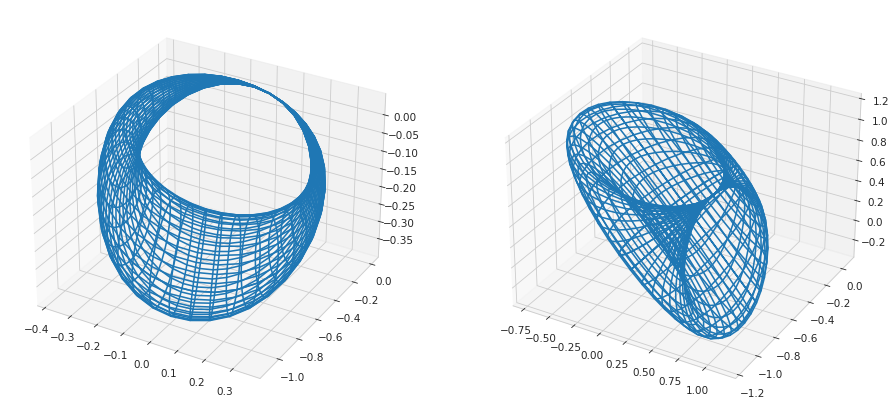

In [4]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(15, 7),dpi=75)

#define subplot grid
ax1 = plt.subplot2grid((1, 2), (0, 0),projection='3d')  
ax2 = plt.subplot2grid((1, 2), (0, 1),projection='3d')  


model_obj.propagate(TP_B)
wf_model = model_obj.visualize_wireframe(index=0)
ax1.plot_wireframe(*wf_model.T, zorder=3)

model_obj2.propagate(TP_B)
wf_model2 = model_obj2.visualize_wireframe(index=0)
ax2.plot_wireframe(*wf_model2.T, zorder=3)

### get fit results with error bars in HEEQ

In [5]:
print('back')
l1l2_rtn = heliosat.coordinates.transform_lonlat(obj.t_launch, obj.particles[:, 1:3], "HCI", "HEEQ")
labels = ["${0}$".format(v["label"]) for k, v in py3dcore.models.TTGHv2.default_parameters().items()]

def print_result(arr, lbl):
    print("{0}: {1:.3f} +/- {2:.3f}".format(lbl, np.mean(arr), np.std(arr)))
    
print_result(l1l2_rtn[:, 0], labels[1])
print_result(l1l2_rtn[:, 1], labels[2])

for i in range(3, 16):
    print_result(obj.particles[:, i], labels[i])
    
print()    
print()    
print('full')
l1l2_rtn2 = heliosat.coordinates.transform_lonlat(obj2.t_launch, obj2.particles[:, 1:3], "HCI", "HEEQ")

    
print_result(l1l2_rtn2[:, 0], labels[1])
print_result(l1l2_rtn2[:, 1], labels[2])

for i in range(3, 16):
    print_result(obj2.particles[:, i], labels[i])
    


back
$L_1$: 89.215 +/- 6.519
$L_2$: -17.537 +/- 4.502
$O$: 160.982 +/- 4.358
$D_{1AU}$: 0.265 +/- 0.027
$w$: 0.626 +/- 0.090
$\delta$: 1.182 +/- 0.285
$R_0$: 20.000 +/- 0.000
$V_0$: 665.862 +/- 164.900
$\tau$: 20.224 +/- 3.429
$n_a$: 1.140 +/- 0.000
$n_b$: 1.640 +/- 0.000
$B_{1AU}$: 27.639 +/- 2.698
$\gamma$: 1.353 +/- 0.424
$V_{SW}$: 313.544 +/- 46.132
$\sigma$: 0.617 +/- 0.437


full
$L_1$: 106.255 +/- 5.087
$L_2$: 32.971 +/- 6.037
$O$: 230.885 +/- 5.726
$D_{1AU}$: 0.332 +/- 0.014
$w$: 0.768 +/- 0.102
$\delta$: 5.098 +/- 0.847
$R_0$: 20.000 +/- 0.000
$V_0$: 697.262 +/- 168.676
$\tau$: 20.099 +/- 3.395
$n_a$: 1.140 +/- 0.000
$n_b$: 1.640 +/- 0.000
$B_{1AU}$: 36.860 +/- 7.472
$\gamma$: 1.204 +/- 0.469
$V_{SW}$: 307.772 +/- 43.774
$\sigma$: 2.395 +/- 0.884


### functions 

In [6]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in minutes
    res_in_days=1/(24*60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)

    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.8
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.6
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.4
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.2
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    
    
    ax.set_axis_off()
    
       
    



def plot_configure2(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=0, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.72
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.53
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    
    ax.set_axis_off()

    

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    obj.propagate(t_snap)
    wf_model = obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
   
   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)  
    
    
  

### measure fields

In [7]:
t1, btot1, bxyz1 = measure(model_obj, "SOLO", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="SOLO_SUN_RTN")
fileout='june_2020_3dcore_fit_solo_back.p'      
pickle.dump([t1,btot1,bxyz1,model_obj], open('data/telloni_2021/'+fileout, "wb"))


t2, btot2, bxyz2 = measure(model_obj2, "SOLO", t_launch2, TP_B  + datetime.timedelta(hours=96), frame="HCI", bframe="SOLO_SUN_RTN")
fileout2='june_2020_3dcore_fit_solo_all.p'      
pickle.dump([t2,btot2,bxyz2,model_obj2], open('data/telloni_2021/'+fileout, "wb"))


skipping check for new kernels (400 Client Error: Bad Request for url: ftp://psa.esac.esa.int/pub/mirror/VENUS-EXPRESS/SPICE/VEX-E-V-SPICE-6-V1.0/DATA/SCLK)
failed to check existing file "ftp://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/spk/solo_ANC_soc-orbit_20200210-20301118_L006_V1_00018_V01.bsp" (400 Client Error: Bad Request for url: ftp://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/spk/solo_ANC_soc-orbit_20200210-20301118_L006_V1_00018_V01.bsp)
failed to check existing file "ftp://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/fk/solo_ANC_soc-sci-fk_V06.tf" (400 Client Error: Bad Request for url: ftp://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/fk/solo_ANC_soc-sci-fk_V06.tf)


### field plot

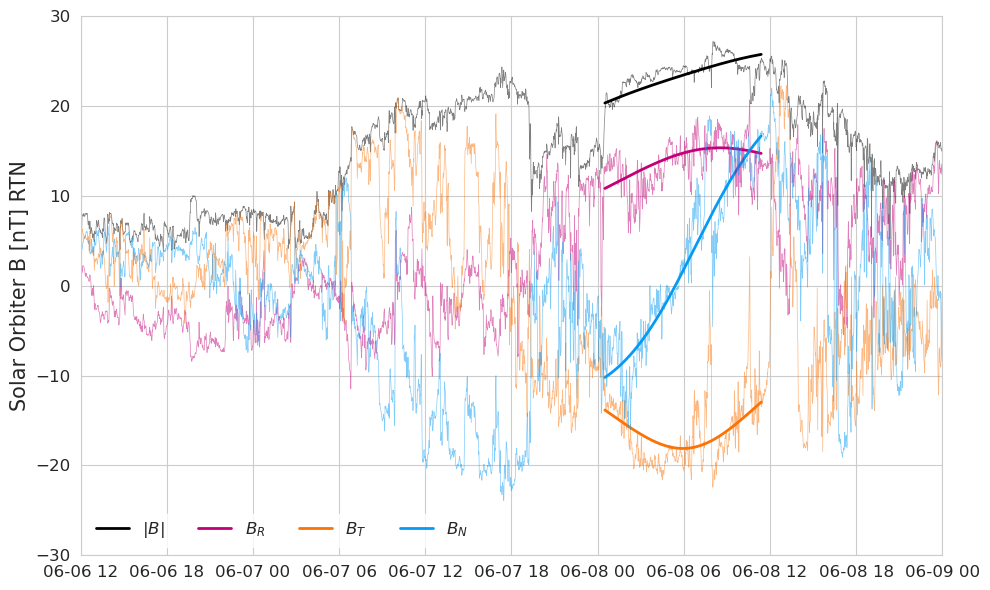

In [8]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(10, 6),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0))  

setalpha=0.5

#back
ax1.plot(t1, btot1, color=C0, label="$|B|$",lw=2)
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$",lw=2)
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$",lw=2)
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$",lw=2)


#all
#ax1.plot(t2, btot2, color=C0, linestyle='--',lw=2)
#ax1.plot(t2, bxyz2[:, 0], color=C1, linestyle='--',lw=2)
#ax1.plot(t2, bxyz2[:, 1], color=C2, linestyle='--',lw=2)
#ax1.plot(t2, bxyz2[:, 2], color=C3, linestyle='--',lw=2)



ax1.plot(sm.time, sm.bt, color=C0,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.bx, color=C1,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.by, color=C2,lw=0.5,alpha=setalpha)
ax1.plot(sm.time, sm.bz, color=C3,lw=0.5,alpha=setalpha)


ax1.legend(loc="lower left", fontsize=12,ncol=4,edgecolor='white')
ax1.set_ylabel('Solar Orbiter B [nT] RTN',fontsize=15)
ax1.set_xlim(datetime.datetime(2020,6,6,12,0),datetime.datetime(2020,6,9,0,0))
ax1.set_ylim(-30,30)

ax1.tick_params(labelsize=12)

plt.tight_layout()

plt.savefig('results/telloni_2021/fit_insitu_june7_2020.pdf',bbox_inches='tight')
plt.savefig('results/telloni_2021/fit_insitu_june7_2020.png', dpi=200)#,bbox_inches='tight')

### simple position plot

failed to check existing file "ftp://spiftp.esac.esa.int/data/SPICE/BEPICOLOMBO/kernels/fk/bc_sci_v06.tf" (400 Client Error: Bad Request for url: ftp://spiftp.esac.esa.int/data/SPICE/BEPICOLOMBO/kernels/fk/bc_sci_v06.tf)
failed to check existing file "ftp://spiftp.esac.esa.int/data/SPICE/BEPICOLOMBO/kernels/spk/bc_mpo_fcp_00079_20181020_20251102_v01.bsp" (400 Client Error: Bad Request for url: ftp://spiftp.esac.esa.int/data/SPICE/BEPICOLOMBO/kernels/spk/bc_mpo_fcp_00079_20181020_20251102_v01.bsp)


current frame_time_num 2020-06-07 00:00:00+00:00


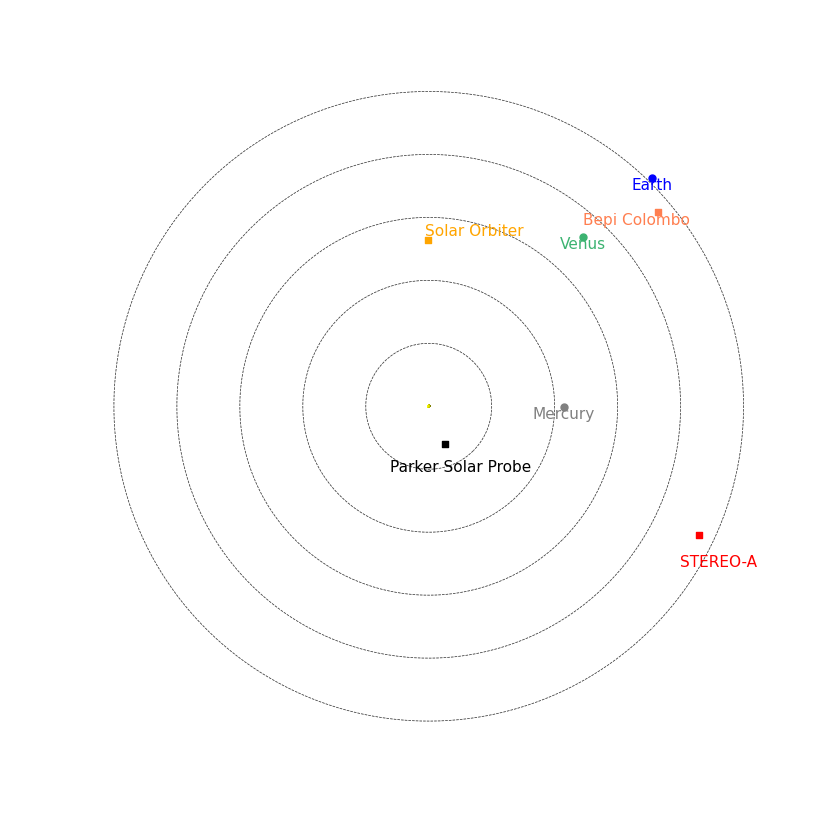

In [10]:
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0),projection='3d')  

######### tilted view
plot_configure(ax1, view_azim=40, view_elev=90, view_radius=.8)

#impact time of CME at solar orbiter 
ti = datetime.datetime(2020, 6, 7, 0,0,0)

#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "Earth", ti, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", ti, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", ti, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", ti, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", ti, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", ti, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", ti, frame="HCI", color=bepi_color,marker='s')


frame_time_num=mdates.date2num(ti) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta_numtime
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth_numtime
earth_timeind=np.argmin(abs(dct))


fsize=15


#planet and spacecraft labels

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='center',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind]+0.07,psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind]-0.15,solo.y[solo_timeind]+0.07,solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind]+0.05,bepi.y[bepi_timeind]-0.05,bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind]+0.09,sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='center',fontsize=fsize-4,verticalalignment='top')

#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.8
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.6
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.4
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.2
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


#a_circle = plt.Circle((0, 0), 1.1,fill=False,zorder=3,linestyle='-')
#ax1.add_artist(a_circle)
plt.savefig('results/plots/positions_solo_apr2020_event_hci.png', dpi=100,bbox_inches='tight')

#plt.savefig('results/plots/positions_solo_apr2020_event_tilt.png', dpi=100,bbox_inches='tight')

## model plot 
 


current frame_time_num 2020-06-07 00:00:00+00:00


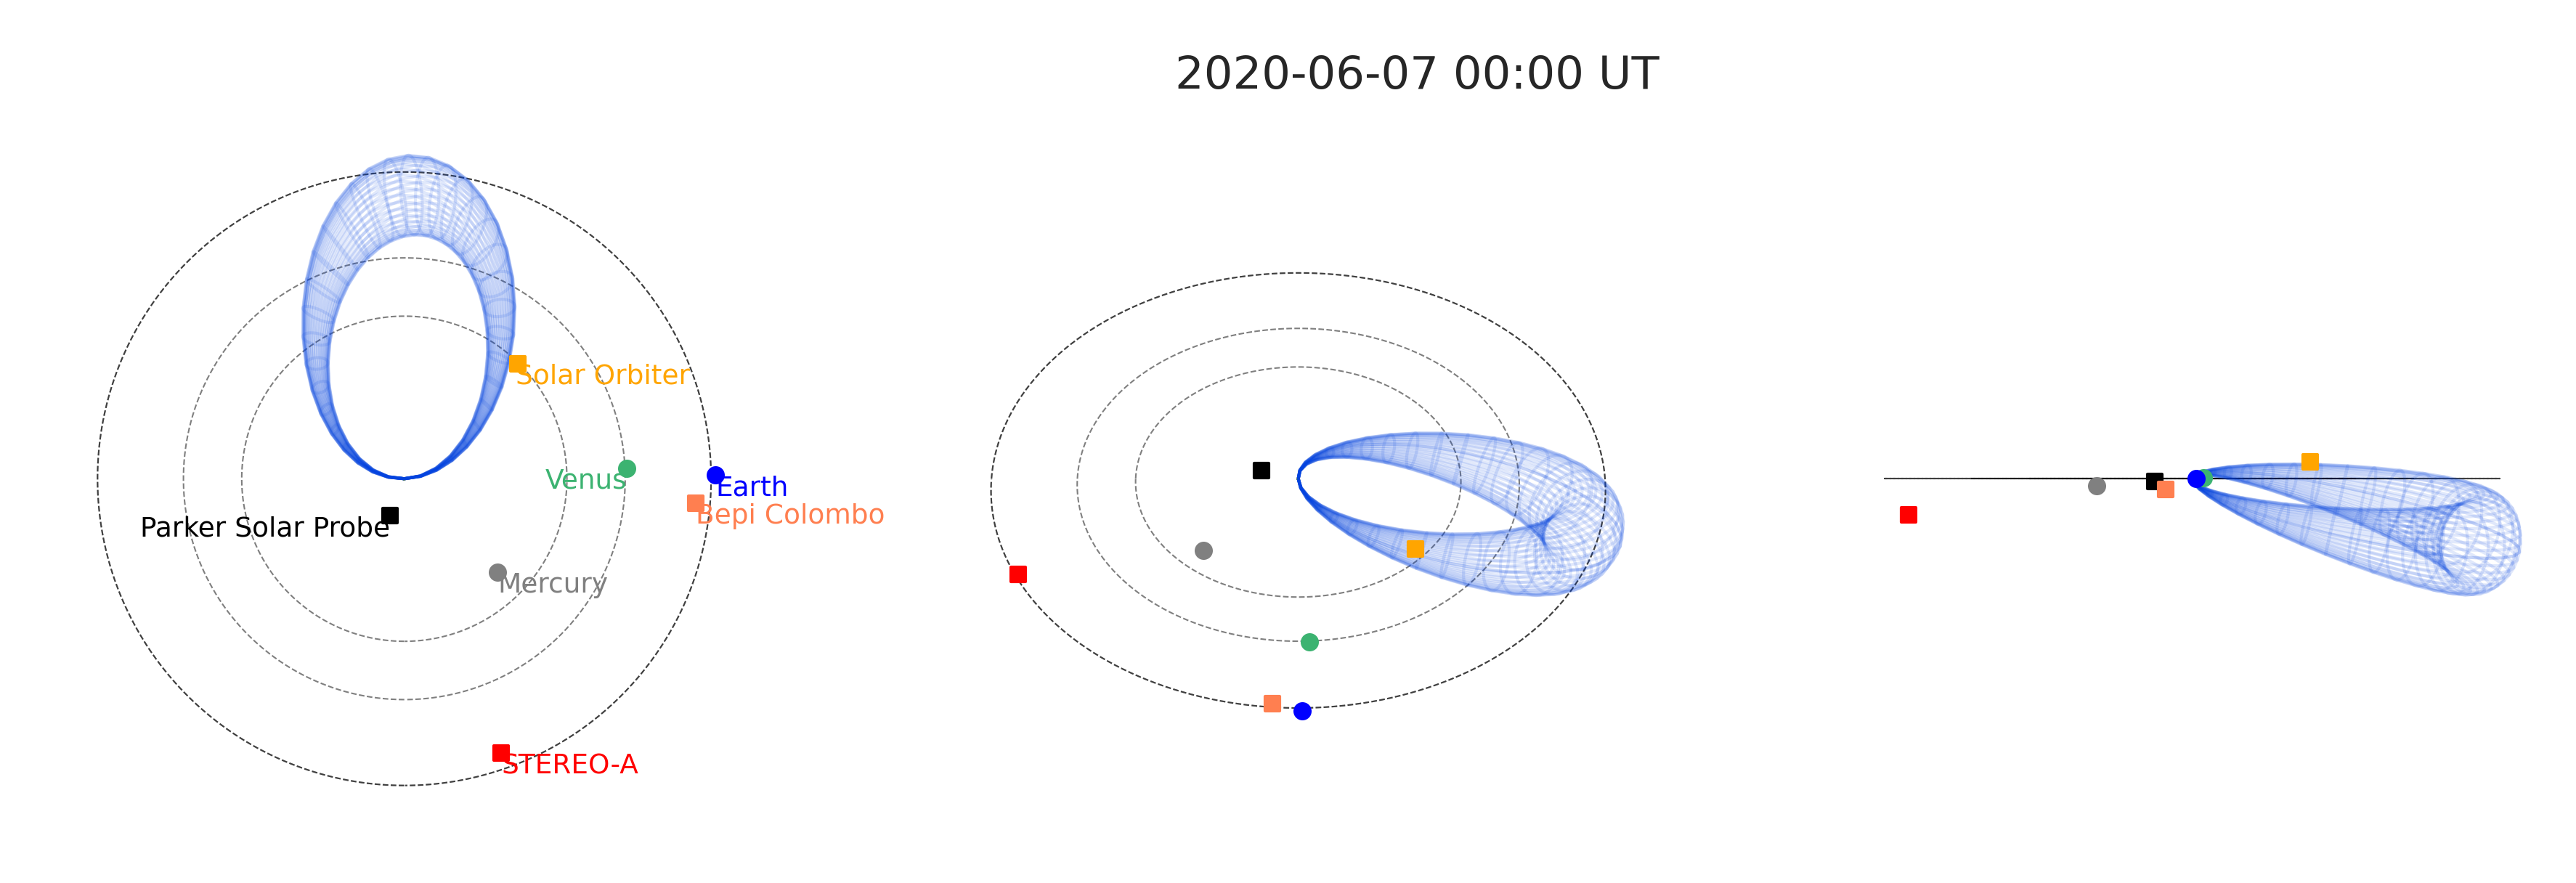

In [11]:
#for field line plots stepsize and initial point for drawing    
field_stepsize=0.001    
q1=np.array([1, .1, np.pi/2])


sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(15, 5),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  

TP_C =  datetime.datetime(2020,6,7,0,0,0)


frame_time_num=mdates.date2num(ti) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta_numtime
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth_numtime
earth_timeind=np.argmin(abs(dct))


########### top view panel
plot_configure2(ax1, view_azim=90, view_elev=90, view_radius=.75)
plot_3dcore(ax1, model_obj, TP_C, color=C_B)
#plot_3dcore(ax1, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

plot_traj(ax1, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax2,0.62,-0.2,0.2,0)


######### tilted view
plot_configure2(ax2, view_azim=180, view_elev=45, view_radius=.75)
plot_3dcore(ax2, model_obj, TP_C, color=C_B)
#plot_3dcore(ax2, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

plot_traj(ax2, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax2, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax2, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax2, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax2, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax2, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax2, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax1,0.3,-0.5,0.5,0)

############### edge on view panel
plot_configure2(ax3, view_azim=180, view_elev=0, view_radius=.75)
plot_3dcore(ax3, model_obj, TP_C, color=C_B)
#plot_3dcore(ax3, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


plot_traj(ax3, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax3, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax3, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax3, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax3, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax3, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax3, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax3,0.4,-0.2,0.2,0)



#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

#panel labels
#plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)


#current time
plt.annotate(parse_time(TP_C).iso[0:16]+' UT',[0.55,0.9],ha='center',xycoords='figure fraction',fontsize=15)


#planet and spacecraft labels
fsize=13

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'Parker Solar Probe', color=psp_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')




#plt.annotate(parse_time(t_launch).iso[0:16],[0.55,0.35],ha='center',xycoords='figure fraction',fontsize=20)
plt.savefig('results/telloni_2021/visual_june7_2020.pdf',bbox_inches='tight')
plt.savefig('results/telloni_2021/visual_june7_2020.png', dpi=200)#,bbox_inches='tight')


## Animation

In [12]:
def make_frame(k):
    

    #for field line plots stepsize and initial point for drawing    
    field_stepsize=0.001    
    q1=np.array([1, .1, np.pi/2])

    sns.set_style('whitegrid')
    fig = plt.figure(1,figsize=(15, 5),dpi=300)

    #define subplot grid
    ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
    ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
    ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  
    #ax4 = plt.subplot2grid((4, 3), (2, 0))  
    #ax5 = plt.subplot2grid((4, 3), (3, 0))  
    #ax6 = plt.subplot2grid((4, 3), (3, 1))  
    #ax7 = plt.subplot2grid((4, 3), (3, 2))  


    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    #ax1.set_position([0,0.3,0.6,0.65], which='both')
    #ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    #ax3.set_position([0.6,0,0.4,0.4], which='both')
    #ax4.set_position([0.05,0.22,0.29,0.17], which='both')
    #ax6.set_position([0.05,0.03,0.29,0.17], which='both')
    #ax5.set_position([0.40,0.22,0.27,0.17], which='both')
    #ax7.set_position([0.40,0.03,0.27,0.17], which='both')
    
    


    frame_time_num=mdates.date2num(tlist[k]) 
    #print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

    #these have their own times
    dct=frame_time_num-psp_numtime
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num-bepi_numtime
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num-solo_numtime
    solo_timeind=np.argmin(abs(dct))

    dct=frame_time_num-sta_numtime
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num-earth_numtime
    earth_timeind=np.argmin(abs(dct))


    ########### top view panel

    plot_configure2(ax1, view_azim=90, view_elev=90, view_radius=.75)
    plot_3dcore(ax1, model_obj, tlist[k], color=C_B)
    #plot_3dcore(ax1, model_obj2, tlist[k], color='black')
    
    plot_traj(ax1, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax1, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax1, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax1, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax1, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax1, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax1, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax2,0.62,-0.2,0.2,0)


    ######### tilted view
    plot_configure2(ax2, view_azim=180-k/5, view_elev=45, view_radius=.75)
    plot_3dcore(ax2, model_obj, tlist[k], color=C_B)
    #plot_3dcore(ax2, model_obj2, tlist[k], color='black')

    #plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
    #plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

    plot_traj(ax2, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax2, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax2, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax2, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax2, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax2, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax2, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax1,0.3,-0.5,0.5,0)

    ############### edge on view panel
    plot_configure2(ax3, view_azim=180, view_elev=0, view_radius=.75)
    plot_3dcore(ax3, model_obj,tlist[k], color=C_B)
    #plot_3dcore(ax3, model_obj2, tlist[k], color='black')

    plot_traj(ax3, "Earth", tlist[k], frame="HCI", color=earth_color)
    plot_traj(ax3, "Venus", tlist[k], frame="HCI", color=venus_color)
    plot_traj(ax3, "Mercury", tlist[k], frame="HCI", color=mercury_color)
    plot_traj(ax3, "SOLO", tlist[k], frame="HCI", color=solo_color,marker='s')
    plot_traj(ax3, "PSP", tlist[k], frame="HCI", color=psp_color,marker='s')
    plot_traj(ax3, "STA", tlist[k], frame="HCI", color=sta_color,marker='s')
    plot_traj(ax3, "BEPI", tlist[k], frame="HCI", color=bepi_color,marker='s')

    #plot_shift(ax3,0.4,-0.2,0.2,0)



    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )


    #panel labels
    #plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)

    #current time
    plt.annotate(parse_time(tlist[k]).iso[0:16]+' UT',[0.55,0.9],ha='center',xycoords='figure fraction',fontsize=15)

    #planet and spacecraft labels
    fsize=11

    ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

    ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'PSP', color=psp_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='left',fontsize=fsize-4,verticalalignment='top')
    ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')

    
    framestr = '%05i' % (k)  
    plt.savefig(animdirectory+'/3dcore_solo_'+framestr+'.jpg',dpi=300)
    plt.close(2)
    print('frame:', k, 'done')


### make animation test frame   

number of frames 576
frame: 100 done


datetime.datetime(2020, 6, 3, 11, 20, tzinfo=datetime.timezone.utc)

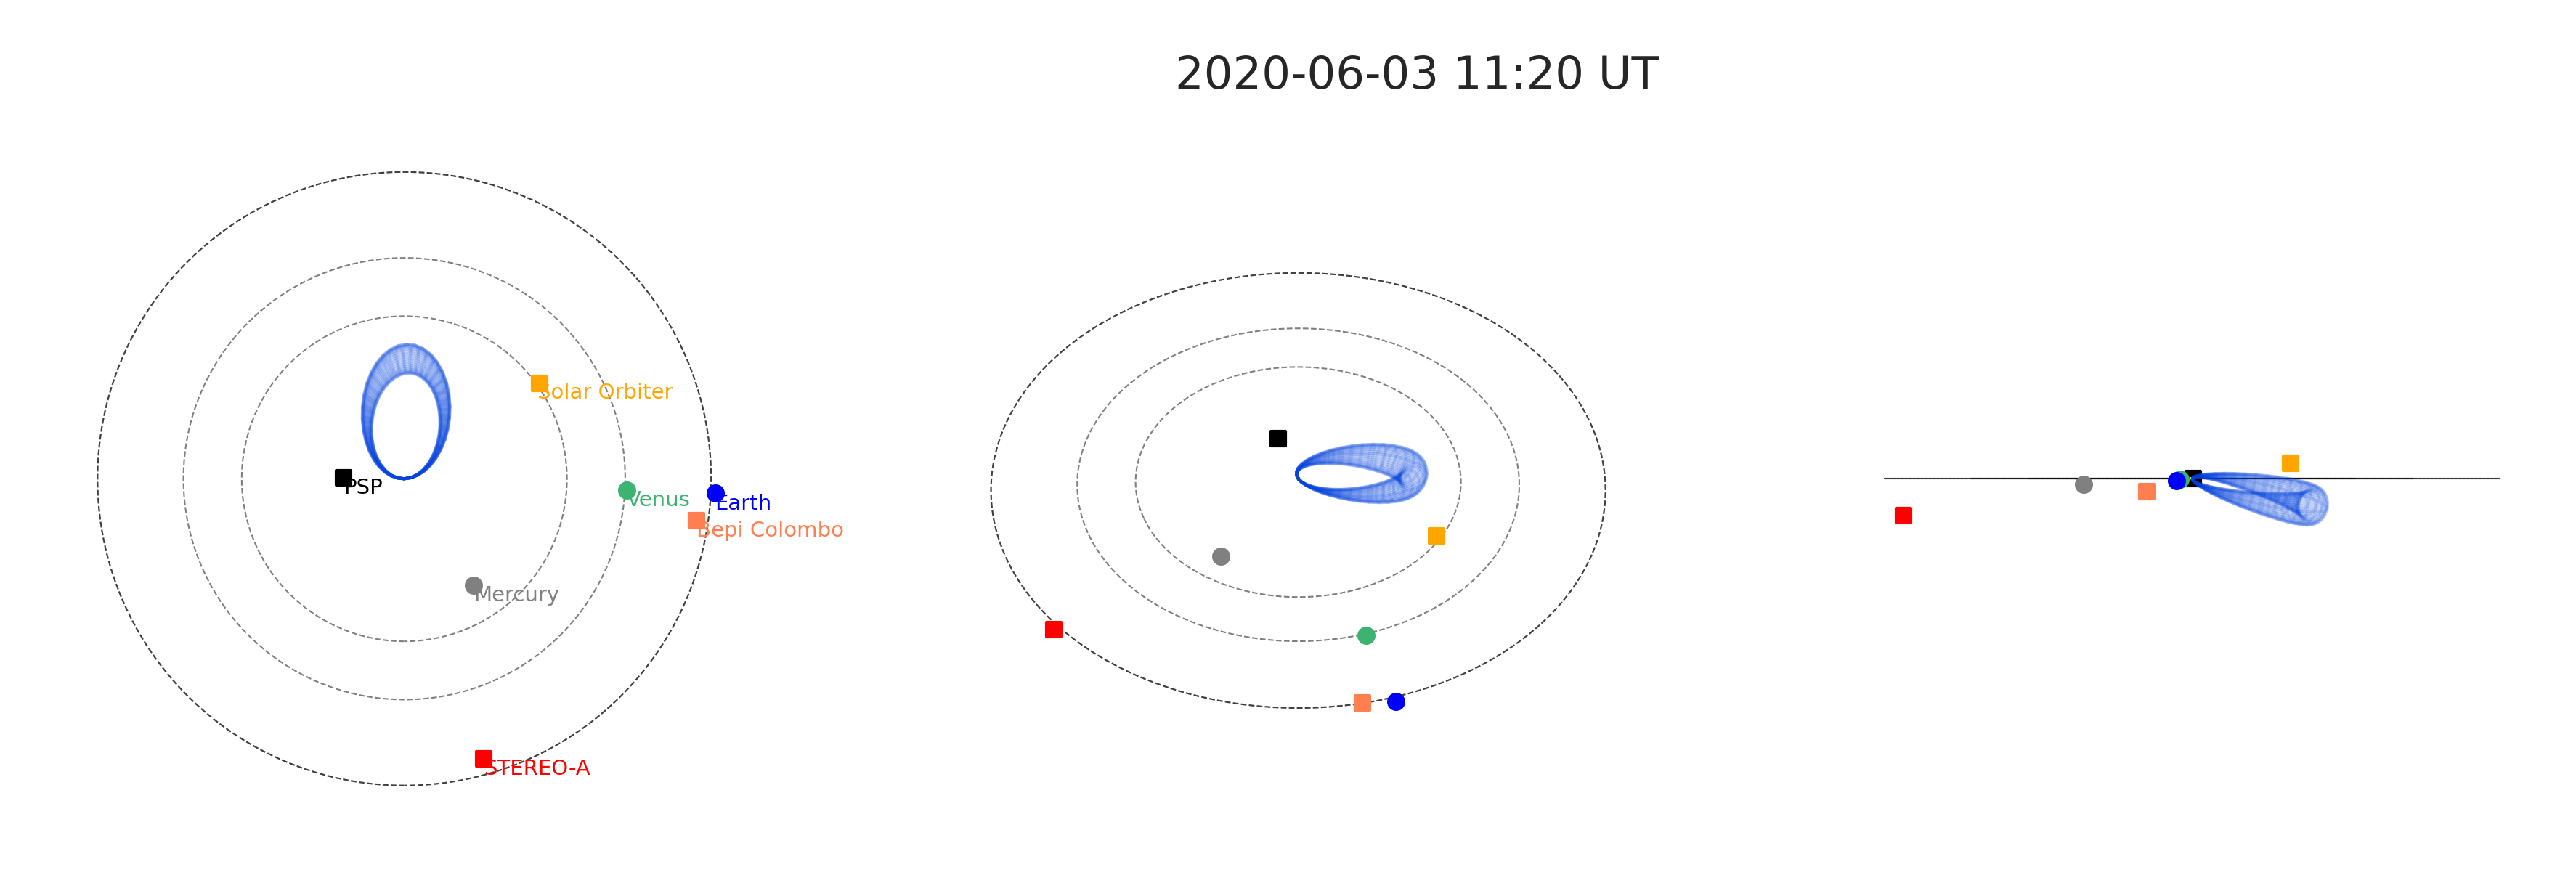

In [13]:
#time for the animation as list
tlist=[]
for i in np.arange(0,24*8*60,20):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,2)

#clock computing time
starttime1=time.time()

################################## single
#make test frames
#for k in np.arange(0,10):#len(tlist)):


#for field line plots stepsize and initial point for drawing    
field_stepsize=0.001   
q1=np.array([0.95, .2, np.pi/2-0.01])

k=100
make_frame(k)
tlist[k]

## Run all frames

In [ ]:
#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=100
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame, input)
pool.close()
#pool.join()

#make movie file
#quality is b ... k
os.system('ffmpeg -r 30 -i '+animdirectory+'/3dcore_solo_%05d.jpg -b 5500k -r 30 results/telloni_2021/anim_3dcore_solo_june7_back.mp4 -y -loglevel quiet')


Using multiprocessing, nr of cores 128 with nr of processes used:  100
frame: 46 done
frame: 18 done
frame: 124 done
frame: 76 done
frame: 32 done
frame: 184 done
frame: 28 done
frame: 30 done
frame: 44 done
frame: 120frame:  done2
 done
frame: 38 done
frame: 60 done
frame: 96 done
frame: 34 done
frame: 42 done
frame: 24 done
frame: 160 done
frame: 62 done
frame: 98frame: done 
110 done
frame: 104frame:  done94
frame:  done174 
done
frame: 138 frame:done
frame:  188frame: done frame:
70 frame:done frame:
852  54 donedone 

done
 frame:102  12done
 done
frame: 78 done
frame: 80 done
frame:frame: 106 done 
frame: frame:26  done74
 92done
 done
frame: 16 done
frame:frame:  6186  donedone

frame:frame: 19 0  donedone

frame: 178 done
frame:frame:  100 156done
 frame: 77 donedone

frame: 36 done
frame: 146 done
frame:frame:  8647frame:   done72done
 done

frame: 150 done
frame: 20 done
frame:frame:  frame:frame:125185    128164done done 
done
done

frame: 198frame:  done
22 done
frame: fram

0